In [1]:
import sys
sys.path.extend(['..', '../', '../..', '../../' ])
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from src.const import paths, datasets, networks
from src.parameters import metrics
from src.datasets.dataset_generators import DatasetGenerators
from src.keras_callback.time_history import TimeHistory
from src.export.csv_export import export_learning_history_to_csv, export_learning_validation_result_to_csv
from src.export.model_export import clear_exported_models, get_best_model_from_directory
from src.export.result_plot import plot_learning_history_metrics, plot_learning_history_loss, plot_learning_history_val_loss, plot_learning_history_val_metrics
from src.keras_model.lenet5_network import LeNet5Network

Using TensorFlow backend.


In [3]:
network_name = networks.lenet5
network = LeNet5Network()
fit_epochs = 50
dataset = datasets.catvsdog
dataset_percentage = '10'


In [4]:
dataset_generators = DatasetGenerators(
    name=f'{dataset}_{dataset_percentage}',
    dataset_dir=paths.data_location,
    image_size=network.image_size,
    batch_size=network.batch_size,
    grayscale=network.grayscale
)

Loading train set for cat-vs-dog_10...
Found 1750 images belonging to 2 classes.
Loading test set for cat-vs-dog_10...
Found 500 images belonging to 2 classes.
Loading validation set for cat-vs-dog_10...
Found 250 images belonging to 2 classes.


In [5]:
model = network.get_compiled_model(
    classes=dataset_generators.test.num_classes
)

In [6]:
checkpoint_path = f'{paths.models_location}{network_name}/{dataset}/'
best_model_path = f'{checkpoint_path}best/'
clear_exported_models(checkpoint_path)
clear_exported_models(best_model_path)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}{{epoch:02d}}-{{val_accuracy}}.h5',
    save_best_only=False,
    save_weights_only=False
)

best_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{best_model_path}best-{{epoch:02d}}-{{val_accuracy}}.h5',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

time_callback = TimeHistory()

model_callbacks = [checkpoint_callback, best_callback, time_callback]

In [7]:
fit_result = model.fit_generator(
    generator=dataset_generators.train,
    epochs=fit_epochs,
    validation_data=dataset_generators.test,
    callbacks = model_callbacks
)

Epoch 1/50
55/55 [==============================] - 4s 71ms/step - loss: 0.9969 - accuracy: 0.5777 - precision: 0.5888 - recall: 0.5797 - val_loss: 0.5668 - val_accuracy: 0.5540 - val_precision: 0.6496 - val_recall: 0.2604

Epoch 00001: val_loss improved from inf to 0.56685, saving model to /Users/igor/Python/CNN-Architecture-Comparison/models/lenet5/cat-vs-dog/best/best-01-0.5540000200271606.h5
Epoch 2/50
55/55 [==============================] - 4s 64ms/step - loss: 0.6327 - accuracy: 0.6594 - precision: 0.6700 - recall: 0.6831 - val_loss: 0.6473 - val_accuracy: 0.5920 - val_precision: 0.5633 - val_recall: 0.8158

Epoch 00002: val_loss did not improve from 0.56685
Epoch 3/50
55/55 [==============================] - 4s 65ms/step - loss: 0.5555 - accuracy: 0.7040 - precision: 0.7058 - recall: 0.7158 - val_loss: 0.4579 - val_accuracy: 0.6080 - val_precision: 0.5899 - val_recall: 0.7149

Epoch 00003: val_loss improved from 0.56685 to 0.45790, saving model to /Users/igor/Python/CNN-Archite

In [8]:
best_saved_model_path = get_best_model_from_directory(best_model_path)
best_saved_model = keras.models.load_model(best_saved_model_path,
    custom_objects= {
        'precision': metrics.precision,
        'recall': metrics.recall
    }
)
validation_result = best_saved_model.evaluate_generator(
    generator=dataset_generators.validate
)

## Results

### Epoch CSV

In [9]:
csv_file_path = f'{paths.results_location}{network_name}/{dataset}-history.csv'
export_learning_history_to_csv(csv_file_path, fit_result, time_callback.times)

epoch,time,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0,0,0,0,0
1,3.9531118869781494,0.5668475031852722,0.5540000200271606,0.6496279835700989,0.2604232132434845,0.9972691707611084,0.5777142643928528,0.5888401865959167,0.5797247886657715
2,3.5480713844299316,0.6472967267036438,0.5920000076293945,0.5632696151733398,0.8157585859298706,0.6315700581414359,0.659428596496582,0.6700044274330139,0.6830713152885437
3,3.6464598178863525,0.4579048156738281,0.6079999804496765,0.5898802280426025,0.7149057388305664,0.5563316562516348,0.7039999961853027,0.7057822942733765,0.7157973647117615
4,3.7845969200134277,0.5174421072006226,0.6079999804496765,0.61244136095047,0.5651922821998596,0.5014796679360526,0.7491428852081299,0.752865731716156,0.782203197479248
5,3.4973580837249756,0.6982275247573853,0.6179999709129333,0.6652979254722595,0.48870620131492615,0.4502823076929365,0.7822856903076172,0.80930495262146,0.7693669199943542
6,3.5140280723571777,0.5888792872428894,

### Epoch plot

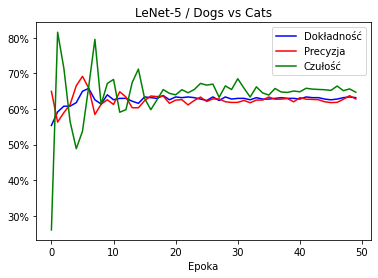

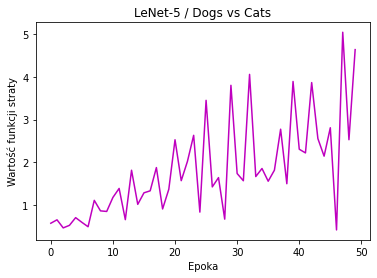

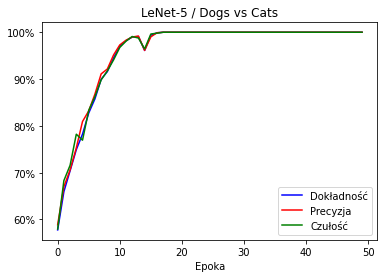

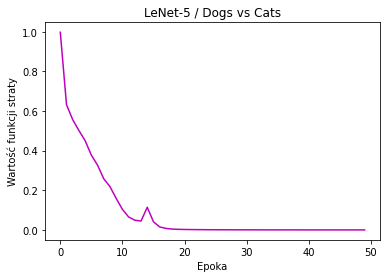

In [10]:
val_metrics_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-val-metrics.png'
val_loss_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-val-loss.png'
metrics_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-metrics.png'
loss_png_file_path = f'{paths.results_location}{network_name}/{dataset}-plot-loss.png'

plot_learning_history_val_metrics(val_metrics_png_file_path, network_name, dataset, fit_result)
plot_learning_history_val_loss(val_loss_png_file_path, network_name, dataset, fit_result)
plot_learning_history_metrics(metrics_png_file_path, network_name, dataset, fit_result)
plot_learning_history_loss(loss_png_file_path, network_name, dataset, fit_result)

### Validation result

In [11]:
csv_file_path = f'{paths.results_location}{network_name}/{dataset}-result.csv'
export_learning_validation_result_to_csv(csv_file_path, validation_result, time_callback.times)

avg_epoch_time,time,val_loss,val_accuracy,val_precision,val_recall
3.5734456539154054,178.67228269577026,2.926726818084717,0.6119999885559082,0.6073252558708191,0.656535267829895
